In [2]:
import torch
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"사용 중인 디바이스: {device}")

사용 중인 디바이스: mps


1. 데이터 준비

In [3]:
import pandas as pd
train = pd.read_csv("./data/train.csv")     # 다콘 원본
texts = (train["제목"].fillna("") + " " + train["키워드"].fillna("")).tolist()

2. KoBERT / KoELECTRA 문장 임베딩

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch, numpy as np

# 더 안정적인 한국어 BERT 모델로 변경
MODEL = "klue/roberta-base"  # KoBERT 대신 KLUE RoBERTa 사용
tok   = AutoTokenizer.from_pretrained(MODEL)
bert  = AutoModel.from_pretrained(MODEL).eval().to(device)

def embed(text_batch):
    try:
        # 텍스트 전처리 - 빈 문자열이나 None 값 처리
        text_batch = [str(text) if text is not None else "" for text in text_batch]
        text_batch = [text.strip() for text in text_batch if text.strip()]
        
        if not text_batch:  # 빈 배치인 경우
            return torch.zeros((0, 768))
        
        # 토크나이징 시 오류 처리
        enc = tok(text_batch, padding=True, truncation=True,
                  return_tensors="pt", max_length=128)
        
        # 디바이스 이동
        enc = {k: v.to(bert.device) for k, v in enc.items()}
        
        with torch.no_grad():
            out = bert(**enc).last_hidden_state[:,0]           # CLS 벡터
        return torch.nn.functional.normalize(out, p=2, dim=1) # L2 정규화
    except Exception as e:
        print(f"임베딩 오류 발생: {e}")
        # 오류 발생 시 빈 텐서 반환
        return torch.zeros((len(text_batch), 768))

# 배치 크기를 더 줄여서 안정성 향상
emb_chunks = []
BATCH = 32  # 배치 크기를 64에서 32로 더 줄임
for i in range(0, len(texts), BATCH):
    batch_texts = texts[i:i+BATCH]
    if batch_texts:  # 빈 배치가 아닌 경우에만 처리
        emb_chunk = embed(batch_texts)
        if emb_chunk.shape[0] > 0:  # 유효한 임베딩이 있는 경우
            emb_chunks.append(emb_chunk.cpu())

if emb_chunks:
    emb = torch.vstack(emb_chunks).numpy().astype("float32")  # (N, 768)
    print(f"임베딩 완료: {emb.shape}")
else:
    print("유효한 임베딩을 생성할 수 없습니다.")
    emb = np.zeros((0, 768))

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


임베딩 완료: (54609, 768)


3. FAISS : 실시간 유사 아이디어 찾기

In [5]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [18]:
import sys
!{str(sys.executable)} -m pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.3 MB/s eta 0:00:00


In [6]:
import faiss

d = emb.shape[1]
index = faiss.IndexFlatIP(d)    # Cosine = Inner Product on normed vectors
index.add(emb)                  # 전체 문장 등록

# 테스트 — 첫 번째 문장과 가장 비슷한 5개 찾기
D, I = index.search(emb[:1], k=5)
print("Top-5 indices:", I[0], "\nSimilarities:", D[0])

Top-5 indices: [    0 27571 50954 29858 35059] 
Similarities: [1.         0.9977637  0.9974578  0.9972697  0.99667114]


4. HDBSCAN : 자동 클러스터링

In [21]:
import sys
!{str(sys.executable)} -m pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.8 MB/s eta 0:00:00


HDBSCAN

In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    metric="euclidean",              # L2 norm 사용(이미 벡터가 정규화되어 있어도 OK)
    min_cluster_size=15,             # 군집 최소 크기(데이터 1% 정도부터 테스트)
    prediction_data=True
).fit(emb)

labels = clusterer.labels_          # -1 = noise
probs  = clusterer.probabilities_
print(pd.Series(labels).value_counts().head())

/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [7]:
import hdbscan
# 전체 데이터의 일부만 사용
sample_size = 10000  # 원하는 샘플 크기
if len(emb) > sample_size:
    indices = np.random.choice(len(emb), sample_size, replace=False)
    emb_sample = emb[indices]
else:
    emb_sample = emb

clusterer = hdbscan.HDBSCAN(
    metric="euclidean",
    min_cluster_size=15,
    prediction_data=True
).fit(emb_sample)

labels = clusterer.labels_ # -1 = nosise
print("클러스터 분포:")
print(pd.Series(labels).value_counts().head())

/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


클러스터 분포:
 0    7632
-1    2337
 1      31
Name: count, dtype: int64


In [8]:
emb.shape

(54609, 768)

/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


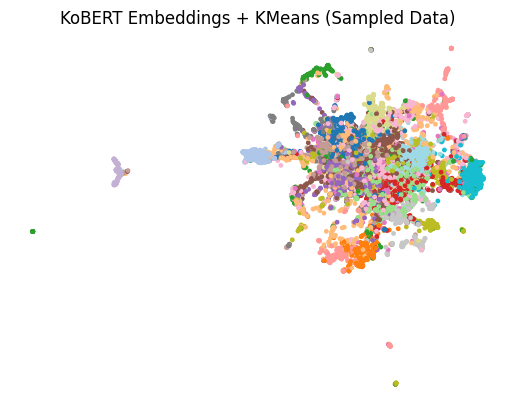

In [12]:
# emb_sample에 대해 KMeans 클러스터링
kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
labels_sample = kmeans.fit_predict(emb_sample)

# UMAP 시각화
umap_2d = umap.UMAP(n_components=2, random_state=42).fit_transform(emb_sample)
plt.scatter(umap_2d[:,0], umap_2d[:,1], c=labels_sample, s=6, cmap="tab20")
plt.title("KoBERT Embeddings + KMeans (Sampled Data)")
plt.axis("off"); plt.show()

In [ ]:
# DBSCAN (HDBSCAN보다 빠름)
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=15)
labels = dbscan.fit_predict(emb)

UMAP 2-D 시각화

In [10]:
import sys
!{str(sys.executable)} -m pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 12.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 29.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [umap-learn]4 [umap-learn]


/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


ValueError: 'c' argument has 54609 elements, which is inconsistent with 'x' and 'y' with size 10000.

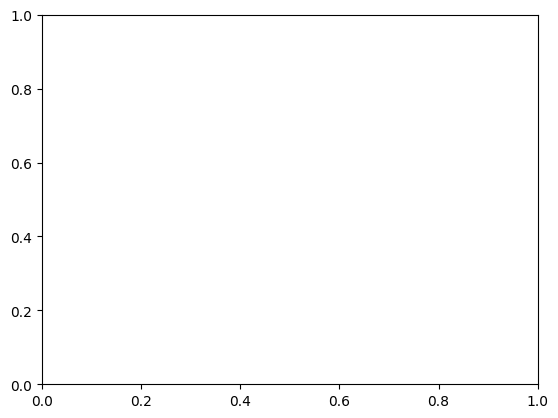

In [11]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Use the same sampled data for UMAP that was used for HDBSCAN
umap_2d = umap.UMAP(n_components=2, random_state=42).fit_transform(emb_sample)
plt.scatter(umap_2d[:,0], umap_2d[:,1], c=labels, s=6, cmap="tab20")
plt.title("KoBERT Embeddings + HDBSCAN (Sampled Data)")
plt.axis("off"); plt.show()

군집별 데이터 분포 및 주요 키워드 분석

(1) 군집별 데이터 개수 (분포)

In [13]:
import pandas as pd
pd.Series(labels_sample).value_counts().sort_index()

0     500
1     388
2     350
3     657
4     323
5     735
6     517
7     514
8     565
9     172
10    795
11    757
12    303
13    806
14    310
15    394
16    464
17    417
18    479
19    554
Name: count, dtype: int64

(2) 군집별 주요 키워드 뽑기

In [14]:
for cluster_idx in range(20):  # n_clusters=20 기준
    cluster_mask = (labels_sample == cluster_idx)
    sample_indices = indices[cluster_mask]
    keywords = train.loc[sample_indices, '키워드'].dropna().astype(str)
    # 키워드가 여러 개일 경우 분리(예: 쉼표, 공백 등)
    all_keywords = []
    for kw in keywords:
        all_keywords.extend(kw.replace(',', ' ').split())
    # 상위 5개 키워드 출력
    top_keywords = pd.Series(all_keywords).value_counts().head(5)
    print(f"[군집 {cluster_idx}] 대표 키워드: {', '.join(top_keywords.index)}")

[군집 0] 대표 키워드: 지원, 용인시, 사업, 신청, 청년
[군집 1] 대표 키워드: 확진자, 코로나19, 감염, 확진, 누적
[군집 2] 대표 키워드: 사고, 발생, 용인시, 화재, 경찰
[군집 3] 대표 키워드: 지역, 용인시, 경기, 경기도, 서울
[군집 4] 대표 키워드: 용인시, 경기, 서울, 지역, 경기도
[군집 5] 대표 키워드: 용인시, 사업, 용인, 계획, 조성
[군집 6] 대표 키워드: 용인시, 사업, 주택, 시설, 설치
[군집 7] 대표 키워드: 혐의, 경찰, A씨, 검찰, 사건
[군집 8] 대표 키워드: 용인시, 진행, 용인, 교육, 프로그램
[군집 9] 대표 키워드: 우승, KLPGA, 대회, 경기, 투어
[군집 10] 대표 키워드: 시장, 용인, 용인시, 이상일, 지원
[군집 11] 대표 키워드: 용인시, 지원, 용인, 지역, 사업
[군집 12] 대표 키워드: 용인시, 사업, 지역, 지원, 용인
[군집 13] 대표 키워드: 경기도, 지역, 용인시, 경기, 사업
[군집 14] 대표 키워드: 용인시, 동물, 농가, 탈출, 마리
[군집 15] 대표 키워드: 용인시, 노선, 버스, 사업, 운행
[군집 16] 대표 키워드: 용인시, 기업, 사업, 회장, 삼성전자
[군집 17] 대표 키워드: 용인시, 의원, 용인, 의회, 특례
[군집 18] 대표 키워드: 아파트, 분양, 단지, 서울, 가구
[군집 19] 대표 키워드: 반도체, 용인, 산업, 조성, 용인시
